In [ ]:
import random as rd

In [ ]:
from importlib import reload

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

In [4]:
import lib

In [5]:
from typing import Tuple

In [28]:
reload(lib)

<module 'lib' from 'C:\\Users\\perrollaz\\Documents\\lib.py'>

# Résumé séances précédentes

1. On a trouvé un modèle linéaire généralisé qui numériquement s'entraine bien.
2. Ce modèle a deux types de paramètres: 
   - les coefficients devant les gaussiennes (décidés automatiquement par l'entrainement)
   - le nombre de Gaussienne et leur dispersion (décidés par l'utilisateur en amont; on les appelle les `hyperparametres`)
3. Lorsque la complexité du modèle augmente trop, l'entrainement permet d'apprendre non seulement la "réalité cachée" mais aussi le bruit aléatoire que l'on souhaite à priori filtré.
4. Pour détecter le deuxième phénomène ("overfitting") on va en fait couper les données en deux parties:
   - la première sera utilisé pour l'entrainement.
   - la deuxième sera utilisé ensuite pour générer une erreur "témoin" qui permettra en cas de décalage de détecter l'overfitting.

In [7]:
def train_test_split(donnees: lib.Donnees, proba=0.7) -> Tuple[lib.Donnees, lib.Donnees]:
    train_points, train_mesures = list(), list()
    test_points, test_mesures = list(), list()
    for point, mesure in donnees:
        if rd.random() < proba:
            train_points.append(point)
            train_mesures.append(mesure)
        else:
            test_points.append(point)
            test_mesures.append(mesure)
            
    return (
        lib.Donnees(points=train_points, mesures=train_mesures),
        lib.Donnees(points=test_points, mesures=test_mesures),
    )
        

In [8]:
realite = lib.Realite(
    gauche=0.0, 
    droite=10.0, 
    fonction=lambda x: np.cos(5 * x) * np.exp(np.sin(x)-x / 10)
)

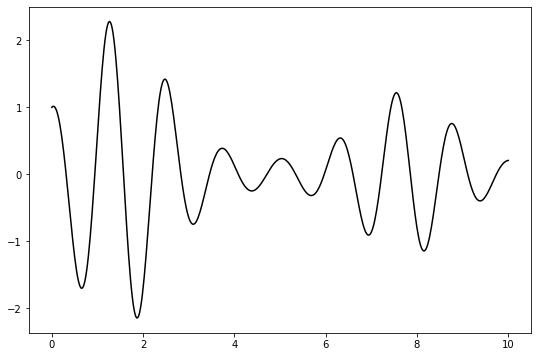

In [9]:
fig, rep = plt.subplots(figsize=(9, 6))
realite.dessine(rep, nb_points=500)

In [10]:
donnees = lib.echantillon_deterministe(
    nb_points=25,
    reel=realite,
    taille_bruit=0.4,
)

In [11]:
donnees

Donnees(points=[ 0.          0.41666667  0.83333333  1.25        1.66666667  2.08333333
  2.5         2.91666667  3.33333333  3.75        4.16666667  4.58333333
  5.          5.41666667  5.83333333  6.25        6.66666667  7.08333333
  7.5         7.91666667  8.33333333  8.75        9.16666667  9.58333333
 10.        ], mesures=[ 1.171517   -0.58796557 -1.90322375  2.31636563 -0.7658076  -1.16829721
  1.69749701 -0.08498773 -0.39638943  0.38112448 -0.40168606 -0.64384917
  0.00795684  0.00996636 -1.19829694  0.1023422  -0.3406968  -0.59564946
  1.2156688  -0.98480098 -0.80060213  0.04120687  0.14493554  0.58228562
  0.15396093])

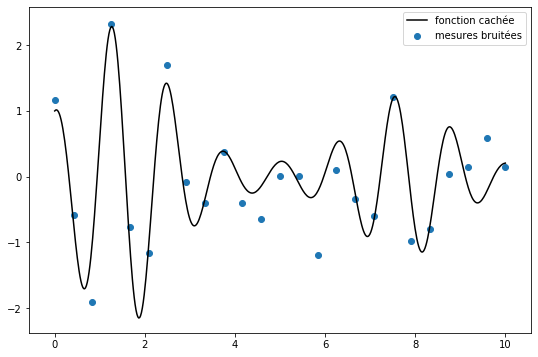

In [12]:
fig, rep = plt.subplots(figsize=(9, 6))
realite.dessine(rep, nb_points=500)
donnees.dessine(rep)
rep.legend()

In [13]:
donnees_train, donnees_test = train_test_split(donnees=donnees, proba=0.7)

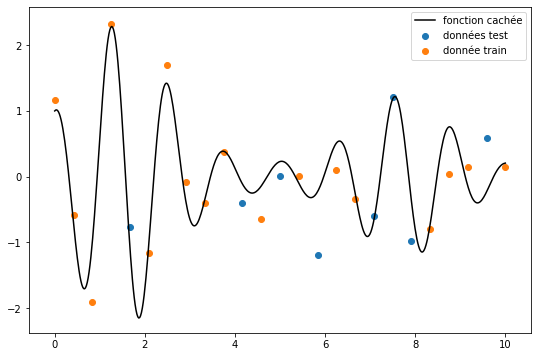

In [14]:
fig, rep = plt.subplots(figsize=(9, 6))
realite.dessine(rep, nb_points=500)
donnees_test.dessine(rep, legende="données test")
donnees_train.dessine(rep, legende="donnée train")
rep.legend()

In [16]:
modele = lib.Modele(nb_bases=10, epsilon=0.5, realite=realite)

In [17]:
modele.entrainement(donnees=donnees_train)

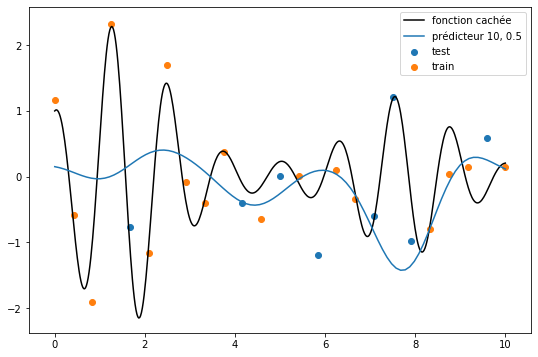

In [20]:
fig, rep = plt.subplots(figsize=(9, 6))
realite.dessine(rep, nb_points=500)
donnees_test.dessine(rep, legende="test")
donnees_train.dessine(rep, legende="train")
modele.dessine(rep)
rep.legend()

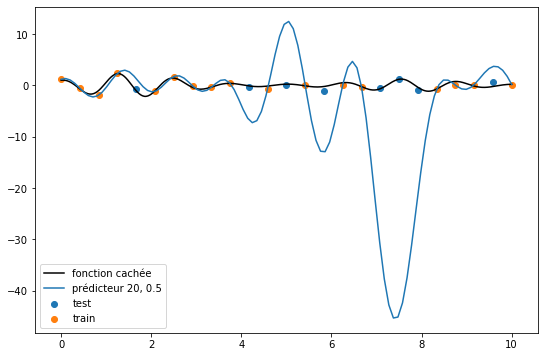

In [29]:
modele = lib.Modele(nb_bases=20, epsilon=0.5, realite=realite)
modele.entrainement(donnees=donnees_train)
fig, rep = plt.subplots(figsize=(9, 6))
realite.dessine(rep, nb_points=500)
donnees_test.dessine(rep, legende="test")
donnees_train.dessine(rep, legende="train")
modele.dessine(rep)
rep.legend()

*Conclusion* Le modèle est suffisamment complexe pour passer par les points d'entrainement, mais aux points bleu les choses se passent mal, le modèle généralise très mal. (Overfitting)

In [23]:
def erreur_quadratique(modele, donnees):
    return np.sum((modele(donnees.points) - donnees.mesures) ** 2) / len(donnees.points)

In [30]:
erreur_quadratique(modele, donnees_test)

478.80073494245846

In [31]:
erreur_quadratique(modele, donnees_train)

7.21127521223394e-05

**Conclusion** on voit que l'erreur d'entrainement est faible alors que l'erreur de tests est un facteur $10^7$ plus élevée, signe d'overfitting.

**Exercice** en utilisant la méthodologie précédente déterminer la complexité optimale pour entrainer le modèle. 
Faites les graphes des erreurs test/entrainement en fonction de la complexité du modèle.

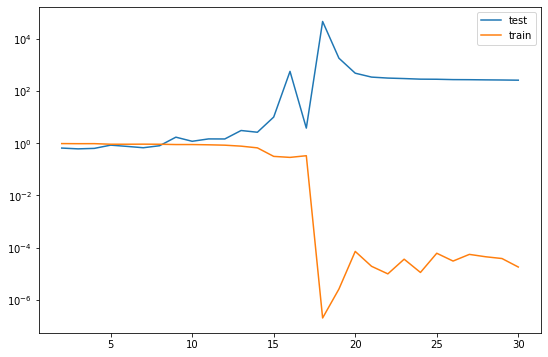

In [34]:
complexites = list(range(2, 31))
erreurs_test = list()
erreurs_train = list()
for complexite in complexites:
    modele = lib.Modele(nb_bases=complexite, epsilon=0.5, realite=realite)
    modele.entrainement(donnees=donnees_train)
    erreurs_test.append(erreur_quadratique(modele, donnees_test))
    erreurs_train.append(erreur_quadratique(modele, donnees_train))

fig, rep = plt.subplots(figsize=(9, 6))
rep.semilogy(complexites, erreurs_test, label="test")
rep.semilogy(complexites, erreurs_train, label="train")
rep.legend()

**Exercice** 
1. Optimiser aussi par rapport à la dispersion des gaussiennes
2. Créer un échantillonnage aléatoire de la réalite et augmenter la taille de l'échantillon.

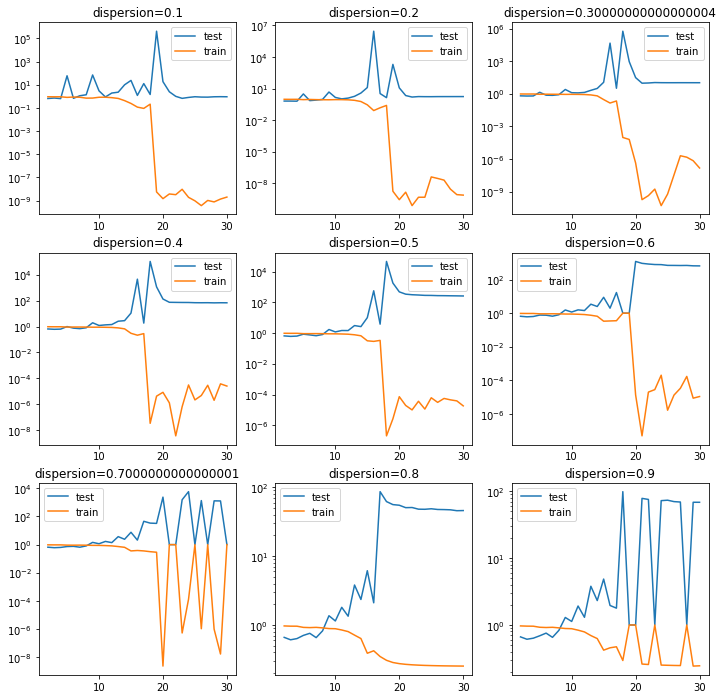

In [37]:
dispersions = np.linspace(0.1, 0.6, 9)
fig, reps = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
complexites = list(range(2, 31))
for dispersion, rep in zip(dispersions, reps.flatten()):
    erreurs_test = list()
    erreurs_train = list()
    for complexite in complexites:
        modele = lib.Modele(nb_bases=complexite, epsilon=dispersion, realite=realite)
        try:
            modele.entrainement(donnees=donnees_train)
        except ValueError:
            erreurs_test.append(1.)
            erreurs_train.append(1.)
        else:
            erreurs_test.append(erreur_quadratique(modele, donnees_test))
            erreurs_train.append(erreur_quadratique(modele, donnees_train))


    rep.semilogy(complexites, erreurs_test, label="test")
    rep.semilogy(complexites, erreurs_train, label="train")
    rep.legend()
    rep.set_title(f"dispersion={dispersion}")

In [40]:
def echantillon_aleatoire(nb_points: int, reel: lib.Realite, taille_bruit: float) -> lib.Donnees:
    points = np.random.uniform(low=reel.gauche, high=reel.droite, size=(nb_points,))
    valeurs = reel.fonction(points)
    mesures = valeurs + np.random.normal(loc=0.0, scale=taille_bruit, size=(nb_points,))
    return lib.Donnees(points=points, mesures=mesures)

In [41]:
donnees_a = echantillon_aleatoire(nb_points=50, reel=realite, taille_bruit=0.4)

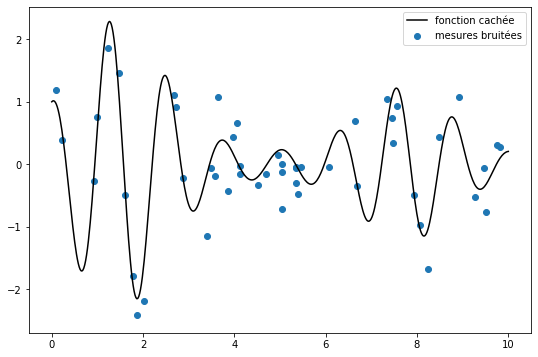

In [42]:
fig, rep = plt.subplots(figsize=(9, 6))
realite.dessine(rep, nb_points=500)
donnees_a.dessine(rep)
rep.legend()

In [43]:
donnees_a_train, donnees_a_test = train_test_split(donnees=donnees_a, proba=0.7)

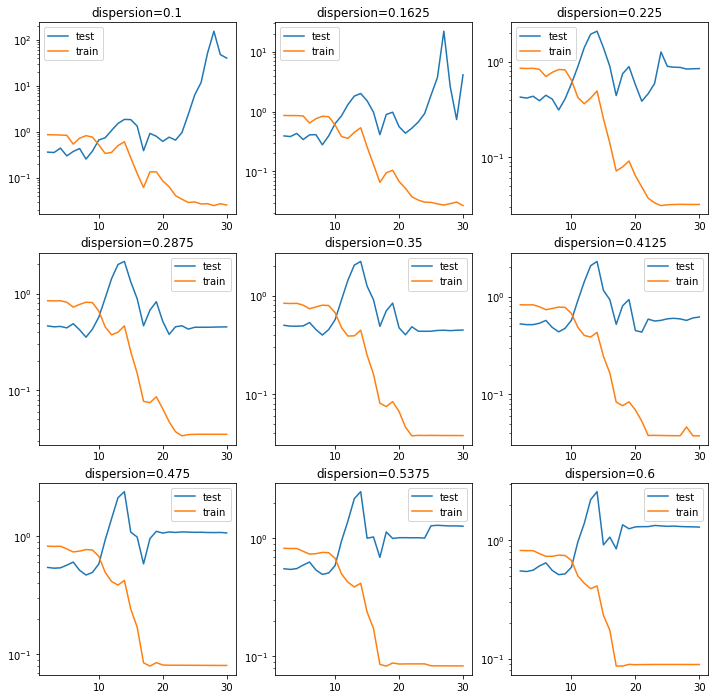

In [44]:
dispersions = np.linspace(0.1, 0.6, 9)
fig, reps = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
complexites = list(range(2, 31))
for dispersion, rep in zip(dispersions, reps.flatten()):
    erreurs_test = list()
    erreurs_train = list()
    for complexite in complexites:
        modele = lib.Modele(nb_bases=complexite, epsilon=dispersion, realite=realite)
        try:
            modele.entrainement(donnees=donnees_a_train)
        except ValueError:
            erreurs_test.append(1.)
            erreurs_train.append(1.)
        else:
            erreurs_test.append(erreur_quadratique(modele, donnees_a_test))
            erreurs_train.append(erreur_quadratique(modele, donnees_a_train))


    rep.semilogy(complexites, erreurs_test, label="test")
    rep.semilogy(complexites, erreurs_train, label="train")
    rep.legend()
    rep.set_title(f"dispersion={dispersion}")